In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem
from ModularCirc import BatchRunner
import json

show_progress = False if os.getenv("JUPYTER_BOOK_BUILD", "false").lower() == "true" else True

In [9]:
# Load the simulation input parameters and summary statistics

n_samples = 2048

sim_path = f'./outputs/simulations/output_{n_samples}_samples/'

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(sim_path, f'input_samples_{n_samples}.csv'))

# Load the boolean mask for failed simulations
with open(os.path.join(sim_path, 'bool_indices.json'), 'r') as f:
    bool_indices = json.load(f)

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(sim_path, f'simulations_summary.csv'))

# Load the input parameters
parameters_json_file = 'parameters_01.json'

In [10]:
# Use ModularCirc's BatchRunner to condense parameter names. This requires setting up the sampler first.
br = BatchRunner()

br.setup_sampler(parameters_json_file)

br._parameters_2_sample

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045),
 'T': (300.0, 1200.0),
 'v_tot': (3500.0, 6500.0)}

In [11]:
# Get column names for parameters up to 'T'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('T') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
0,324.140512,0.429410,970.557289,2.593650,5.759509,141.391649,5.535208,3.645771,0.302181,0.614511,13.751520,0.074688,1.310537,3.983934,10.192377,0.040153,458.957450
1,213.211374,0.168363,1134.582900,3.092750,11.457833,81.051107,6.337772,5.927350,0.476733,0.449234,6.030600,0.032403,0.538215,2.789425,7.998957,0.014420,1177.644680
2,128.027561,0.373035,664.791603,1.807716,9.775524,110.934879,3.831676,4.690519,0.657067,0.244713,9.303856,0.023797,1.070499,3.257826,7.055576,0.027896,771.390037
3,287.120769,0.262023,1448.888220,3.761496,8.444797,167.239972,7.529157,2.905174,0.338195,0.522401,10.791995,0.054236,0.830979,2.014983,14.871574,0.027224,590.140139
4,261.317508,0.322630,1342.111306,4.190009,7.184780,154.969280,3.238999,4.237066,0.583734,0.372392,7.797148,0.048891,1.195902,2.575591,12.781972,0.020054,650.410479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,261.101611,0.261382,685.537472,3.721722,9.839757,78.661601,3.416618,4.155957,0.280508,0.271551,5.030452,0.032721,0.924717,3.177584,11.167055,0.028659,964.683503
2044,287.329562,0.323235,998.297711,3.291562,10.530699,133.110328,8.127906,3.052351,0.529915,0.619758,13.246246,0.041971,1.039666,4.489666,11.499308,0.036120,793.004950
2045,128.141604,0.283698,1396.881532,2.277480,7.231221,189.277109,4.324956,4.855710,0.245566,0.342032,6.618851,0.065123,0.799082,2.284403,9.308001,0.019287,611.699799
2046,213.119531,0.379612,741.421257,4.124279,5.566558,152.640929,6.506589,6.052502,0.394962,0.320269,8.642398,0.049228,1.341140,3.690315,5.862190,0.040821,437.452320


In [12]:
# Drop all the rows from input_params that correspond to entries in bool_indices
input_params = input_params.drop(bool_indices)

In [13]:
Y = summary_stats['p_ao_mean'].values

In [14]:
em = AutoEmulate()
em.setup(X = input_params[parameter_names], 
         y = Y, 
         models = ['gp', 'svm','lgbm'],
         n_jobs=-1)

,Values
Simulation input shape (X),"(2039, 17)"
Simulation output shape (y),"(2039,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


In [15]:
best_model = em.compare()

Cross-validating:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,None,LightGBM,lgbm,0,30.853290,0.698976
1,None,GaussianProcess,gp,0,31.723093,0.681764
2,None,GaussianProcess,gp,2,34.181911,0.672093
3,None,GaussianProcess,gp,3,33.882852,0.653657
4,None,LightGBM,lgbm,2,35.539126,0.645537
5,None,GaussianProcess,gp,1,36.662272,0.639999
6,None,LightGBM,lgbm,1,36.707606,0.639108
7,None,GaussianProcess,gp,4,36.183812,0.610827
8,None,LightGBM,lgbm,4,36.755513,0.598432
9,None,LightGBM,lgbm,3,36.647775,0.594826


In [17]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,None,33.2858,0.6385


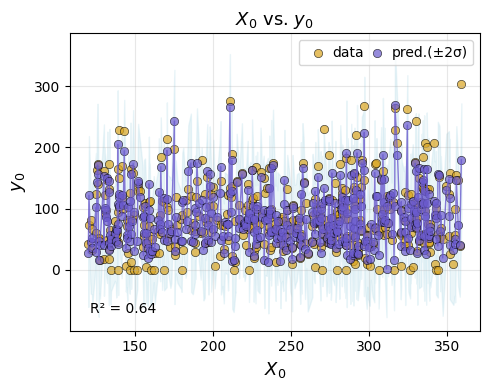

In [18]:
em.plot_eval(gp)

In [19]:
best_emulator = em.refit(gp)

In [23]:
# Extract parameter names and bounds from the dictionary
parameters_range = br._parameters_2_sample

# Drop the 'v_tot' parameter if it exists
if 'v_tot' in parameters_range:
    del parameters_range['v_tot']

parameters_range

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045),
 'T': (300.0, 1200.0)}

In [ ]:
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}

In [14]:
em.sensitivity_analysis(problem=problem)

ValueError: X has 18 features, but StandardScaler is expecting 17 features as input.